In [64]:
from external_potential import Framework, PotentialType
from dft_ad_jax import *
from si_units import *
from glob import glob
import numpy as np
from feos.dft import *
from feos.pcsaft import PcSaftParameters as PcSaftParametersFeos
import jax.numpy as jnp
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import traceback
import os
import csv
from datetime import datetime
import json
import matplotlib.pyplot as plt

In [20]:
temperature = 298 * KELVIN
pressure = 1*BAR

In [137]:
with open("dreiding.json", "r") as file:
    solid_parameters = json.load(file)

components = ['methane']
fluid_parameters = {
    "methane": {"m": 1.0, "sigma": 3.70051, "epsilon_k": 150.07147},
}
fluid_file = 'parameters/pcsaft/esper2023.json'
pcsaft_params = pcsaft_from_file(components, fluid_file)
params_feos = PcSaftParametersFeos.from_json(components, fluid_file)
func = HelmholtzEnergyFunctional.pcsaft(params_feos, FMTVersion.AntiSymWhiteBear)
rc = 12.0
ngrid = 32
base_solver = {
    "damp_coeff_1": 0.01,   # vorher: "damping_coefficient_1"
    "damp_coeff_2": 0.015,   # vorher: "damping_coefficient_2"
    "max_iter_1": 50,
    "max_iter_2": 300,
    "tol": 1e-4,
}
state = State(func, temperature, pressure=pressure)

In [138]:
pcsaft_params

Parameter set with: `m`: [1.], `sigma`: [3.70051], `epsilon_k`: [150.07147], `k_ij`: 0.0.

In [139]:
framework = Framework('/Users/danielbock/MOF_CIF/2008[ZnSi][nan]3[ASR]1.cif')

grid = Grid(
    n_grid=[ngrid]*3,  # 3D Grid definieren
    length=framework.unitcell.lattice.lengths,
    skew_angles=framework.unitcell.lattice.angles,
    lanczos_sigma=True
)

dft  = DFT(grid, pcsaft_params, temperature / KELVIN)

In [140]:
vext_pot = framework.calculate_external_potential(
    ngrid=(ngrid,)*3, 
    interaction_potential_type=PotentialType.LennardJones, 
    cutoff_radius=12.0, 
    fluid_parameters=fluid_parameters, 
    solid_parameters=solid_parameters, 
    #binary_interaction_parameters=binary, 
    #tail_correction_type='RASPA', 
    #block_files=['block1.res', 'block2.res'],
)   
#print(vext_pot.external_potential_k)

In [141]:
# externe Potential vorbereiten
ext = vext_pot.external_potential_k / (temperature/KELVIN)
#ext = jnp.asarray(ext, dtype=jnp.float32)
ext = jnp.clip(ext, -10.0, 10.0)

# Bulk Dichte
density_bulk = jnp.array(state.partial_density * NAV * ANGSTROM**3)
density_bulk_dim = density_bulk[:, None, None, None] * jnp.ones([len(components)] + [ngrid]*3)

# Startprofil
rho_init = density_bulk_dim
#rho_init = jnp.clip(rho_init, 1e-12, None)

density_eq, res1, res_iter1 = dft.picard_iteration(
    rho_init,
    density_bulk,
    dft.df_drho(density_bulk_dim)[:, 0, 0, 0],
    ext,
    max_iter=base_solver["max_iter_1"],
    damping_constant=base_solver["damp_coeff_1"],
    tol=base_solver["tol"]
)
density_eq, res2, res_iter2 = dft.picard_iteration(
    density_eq,
    density_bulk,
    dft.df_drho(density_bulk_dim)[:, 0, 0, 0],
    ext,
    max_iter=base_solver["max_iter_2"],
    damping_constant=base_solver["damp_coeff_2"],
    tol=base_solver["tol"]
)

 57%|█████████████████████████████████████▌                            | 171/300 [00:00<00:00, 288.49it/s]


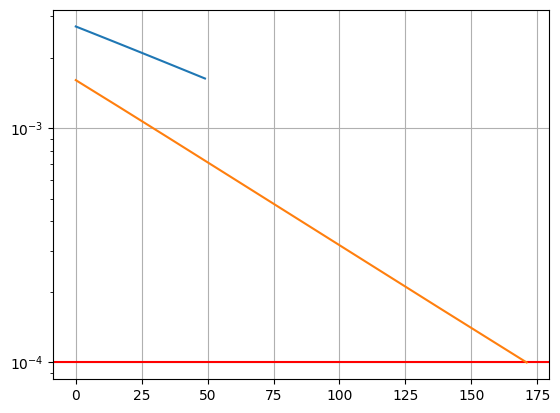

In [142]:
plt.axhline(base_solver['tol'], c='r')
plt.grid()
plt.yscale('log')
plt.plot(res_iter1)
plt.plot(res_iter2)

In [143]:
res2 < base_solver['tol']

Array(True, dtype=bool)

In [146]:
density_bulk

Array([2.4351e-05], dtype=float32)

In [148]:
dft.df_drho(density_bulk_dim)

Array([[[[-0.00375835, -0.00375835, -0.00375835, ..., -0.00375835,
          -0.00375835, -0.00375835],
         [-0.00375835, -0.00375835, -0.00375835, ..., -0.00375835,
          -0.00375835, -0.00375835],
         [-0.00375835, -0.00375835, -0.00375835, ..., -0.00375835,
          -0.00375835, -0.00375835],
         ...,
         [-0.00375835, -0.00375835, -0.00375835, ..., -0.00375835,
          -0.00375835, -0.00375835],
         [-0.00375835, -0.00375835, -0.00375835, ..., -0.00375835,
          -0.00375835, -0.00375835],
         [-0.00375835, -0.00375835, -0.00375835, ..., -0.00375835,
          -0.00375835, -0.00375835]],

        [[-0.00375835, -0.00375835, -0.00375835, ..., -0.00375835,
          -0.00375835, -0.00375835],
         [-0.00375835, -0.00375835, -0.00375835, ..., -0.00375835,
          -0.00375835, -0.00375835],
         [-0.00375835, -0.00375835, -0.00375835, ..., -0.00375835,
          -0.00375835, -0.00375835],
         ...,
         [-0.00375835, -0.00375835

In [151]:
!git push

/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Everything up-to-date


In [152]:
!git status

On branch main
nothing to commit, working tree clean
